In [1]:
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew
from numpy import convolve
import matplotlib.pyplot as plt
from scipy.interpolate import spline
import itertools
import math
from statistics import mode
from scipy.fftpack import *
from sklearn.tree import DecisionTreeClassifier
import scipy
import os
import csv
import pickle
from __future__ import print_function
from scipy.signal import butter, lfilter, freqz

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn import svm

In [3]:
# Functions
def get_data(persons, if_present, sensors):
    global label
    temp_data = []
    suffix = '.csv'
    activities = ['sit', 'walk', 'lay', 'stand']
    
    
    temp_df = []
    all_data = []
    for per, person in enumerate(persons):
        act_data = []
        for act, activity in enumerate(activities):
            #print(activity)
            if( if_present[per][act] == 1):
                sens_data = []
                temp_df = []
                for sensor in sensors:
                    temp_df.append(pd.read_csv('results/' + person +'/' + sensor + '-' + activity + '.csv'))
                min_len = min([len(sensor_df) for sensor_df in temp_df])
                sens_data = temp_df[0].loc[:min_len-1,:]
                for sensor_df in temp_df[1:]:
                    sens_data = pd.concat([sens_data.loc[:, :sens_data.columns[-2]], sensor_df.loc[:min_len-1, :]], axis=1)

                act_data.append(sens_data)
                
        pers_data = act_data[0]
        
        for a_data in act_data[1:]:
            pers_data = pers_data.append(a_data)
            
        all_data.append(pers_data)    
    
    data = all_data[0]
    for a_data in all_data[1:]:
        data = data.append(a_data)
        
    
    columns = data.columns
    data.columns = [i if i== len(columns)-1 else columns[i] for i in range(len(columns))]
    label_col = len(data.columns) - 1
    
    train_data, test_data = train_test_split(data, test_size=0.2,shuffle=True)
    
    train_labels = train_data[label_col]
    train_data = train_data.drop(label_col, axis=1)
    
    test_labels = test_data[label_col]
    test_data = test_data.drop(label_col, axis=1)
    
    labels = data[label_col]
    data = data.drop(label_col, axis=1)
    
    train_labels = train_labels.astype('int')
    test_labels = test_labels.astype('int')
    labels = labels.astype('int')
    
    return data, labels, train_data, train_labels, test_data, test_labels

def readData(label,feature):
    suffix = '.csv'
    filename = os.path.join('data/csv/',label,feature+suffix)
    dataframe = pd.read_csv(filename,header=None)
    dataframe.columns = ['id','x','y','z','a','label']
    return dataframe

def stft(x, fftsize=256, overlap=2):   
    hop = fftsize // overlap
    w = scipy.hanning(fftsize+1)[:-1]
    return np.array([np.fft.fft(w*x[i:i+fftsize]) for i in range(0, len(x)-fftsize, hop)])

def get_fft(x):   
    return np.fft.fft(x)
    
def get_frequency(time):
    total_time = time[-1] - time[0]
    total_samples = len(time)
    frequency = (total_samples * 1000) // total_time
    return total_time, total_samples, frequency

def basicFeats(x, fftsize=256, overlap=2):
    meanamp = []
    maxamp = []
    minamp = []
    stdamp = []
    mad=[]
    hop = fftsize // overlap
    for i in range(0, len(x)-fftsize, hop):
        meanamp.append(np.array(np.mean(x[i:i+fftsize])))
        maxamp.append(np.array(np.max(x[i:i+fftsize])))
        minamp.append(np.array(np.min(x[i:i+fftsize])))
        stdamp.append(np.array(np.std(x[i:i+fftsize])))
        mad.append(np.array(np.median(np.abs(x[i:i+fftsize] - np.median(x[i:i+fftsize])))))
    return meanamp, maxamp, minamp, stdamp, mad

def feature(x, y, z, m, fftsize=256, overlap=2):
    energyamp_m = []
    kurtosisamp_m = []
    skewamp_m = []
    meanamp_x, maxamp_x, minamp_x, stdamp_x, mad_x = basicFeats(x, fftsize)
    meanamp_y, maxamp_y, minamp_y, stdamp_y, mad_y = basicFeats(y, fftsize)
    meanamp_z, maxamp_z, minamp_z, stdamp_z, mad_z = basicFeats(z, fftsize)
    meanamp_m, maxamp_m, minamp_m, stdamp_m, mad_m = basicFeats(m, fftsize)
    
    hop = fftsize // overlap
    for i in range(0, len(m)-fftsize, hop):
        energyamp_m.append(np.array(np.sum(np.power(m[i:i+fftsize],2))))
        kurtosisamp_m.append(kurtosis(m[i:i+fftsize]))
        skewamp_m.append(skew(m[i:i+fftsize]))
                
    return [meanamp_x, maxamp_x, minamp_x, stdamp_x, mad_x, meanamp_y, maxamp_y, minamp_y, stdamp_y, mad_y, 
            meanamp_z, maxamp_z, minamp_z, stdamp_z, mad_z, meanamp_m, maxamp_m, minamp_m, stdamp_m, mad_m, 
            energyamp_m, kurtosisamp_m, skewamp_m]

def normalize_fft_feat(features_list):
    ret_feat = []
    for feat in features_list:
        ret_feat.append(feat / np.linalg.norm(feat))
    
    return ret_feat
    
def normalize_feat(features_list):
    ret_feat = []
    for feat in features_list:
        ret_feat.append(feat / np.linalg.norm(feat))
    
    return ret_feat
            
def five_point_smoothing(m):
    m_smooth = np.zeros(len(m))
    m_smooth = m;
    for i ,val in enumerate(m_smooth[2 : (len(m_smooth) -2)]):
        m_smooth[i] = (m_smooth[i-2] + m_smooth[i-1] + m_smooth[i] + m_smooth[i+1] + m_smooth[i+2])/5
        
    return m_smooth

def inter_quartile_range(x, y, z, fftsize=256, overlap=2):
    """Calculates inter-quartile range"""
    iqr_x = []
    iqr_y = []
    iqr_z = []
    hop = fftsize // overlap
    for i in range(0, len(x)-fftsize, hop):
        iqr_x.append(np.subtract(*np.percentile(x[i:i+fftsize], [75, 25])))
        iqr_y.append(np.subtract(*np.percentile(y[i:i+fftsize], [75, 25])))
        iqr_z.append(np.subtract(*np.percentile(z[i:i+fftsize], [75, 25])))
    return iqr_x, iqr_y, iqr_z

def sma(x, y, z, fftsize=256, overlap=2):
    """Calculates signal magnitude area"""
    abs_x = []
    abs_y = []
    abs_z = []
    hop = fftsize // overlap
    for i in range(0, len(x)-fftsize, hop):
        abs_x.append(np.absolute(x[i:i+fftsize]))
        abs_y.append(np.absolute(y[i:i+fftsize]))
        abs_z.append(np.absolute(z[i:i+fftsize]))
    return [np.mean(x+y+z) for x,y,z in zip(abs_x, abs_y, abs_z)]

def calc_jerk(acc, ts):
    jk = [0]* len(acc)
    for i in range(1,len(acc)):
        jk[i-1] = 1000*(acc[i] - acc[i-1])/(ts[i] - ts[i-1])
    return jk

def get_jerk(x,fftsize=256, overlap=2):
    jerk_x=[]
    hop = fftsize // overlap
    for i in range(0, len(x)-fftsize, hop):
        jerk_x.append(np.array(np.mean(x[i:i+fftsize])))   
    
    return jerk_x

def get_window_label(labels, fftsize=256, overlap=2):
    hop = fftsize // overlap
    ret_labels = []
    for i in range(0, len(labels)-fftsize, hop):
        ret_labels.append(mode(labels[i:i+fftsize]))
    
    return ret_labels


In [4]:
#global dict
label = {'sitting' : 0, 'walking' : 1, 'laying_down' : 2, 'standing' : 3, 'unknown' : 4}


def compute_feats(*dataframes, show_plots=False):
    show_plots=False
    global label
    #df = pd.DataFrame(columns=list(range(60)))
    for counter, data in enumerate(dataframes):
        
        time, x, y, z, _, str_label = np.array(data[0]), np.array(data[1]), np.array(data[2]), np.array(data[3]), \
                                        np.array(data[4]), np.array(data[5])        
        
        total_time, total_sample, freq = get_frequency(time)
        #3 seconds time frame
        window_size = 5 * freq
        
        labels = [label[str_label[i]] for i in range(len(str_label))]
        window_labels = get_window_label(labels, fftsize=window_size)
        #Calculate the Frequency domain
        x = five_point_smoothing(x)
        y = five_point_smoothing(y)
        z = five_point_smoothing(z)
        
        ft_x = get_fft(x)
        ft_x = np.abs(ft_x)
        ft_y = get_fft(y)
        ft_y = np.abs(ft_y)
        ft_z = get_fft(z)
        ft_z = np.abs(ft_z)
        
        
        #Amplitude Calculation
        mpre = x * x + y * y + z * z
        m = np.sqrt(mpre)
        #Low pass filtering (5 point smoothing)
        if show_plots:
            plt.plot(m[:4000])
            plt.title('Accelerometer Data - '+str_label[0])
            plt.ylabel('Amplitude')
            plt.xlabel('Time')
            plt.show()
        
        #Jerk
        jerk_x = calc_jerk(x, time)
        jerk_x = get_jerk(jerk_x, fftsize=window_size)
        jerk_y = calc_jerk(y, time)
        jerk_y = get_jerk(jerk_y, fftsize=window_size)
        jerk_z = calc_jerk(z, time)
        jerk_z = get_jerk(jerk_z, fftsize=window_size)
        
        #FFT features
        stft_signal = stft(m, fftsize=window_size)
        energy_signal = []
        for i, amp in enumerate(stft_signal):
            energy_signal.append(np.sum(np.power(abs(stft_signal[i]),2)))
        
        features_list = feature(x, y, z, m, fftsize=window_size)
        features_list.append(energy_signal)
        diff_x = np.subtract(features_list[1], features_list[2])
        diff_y = np.subtract(features_list[6], features_list[7])
        diff_z = np.subtract(features_list[11], features_list[12])
        diff_m = np.subtract(features_list[16], features_list[17])
        features_list.append(diff_x)
        features_list.append(diff_y)
        features_list.append(diff_z)
        features_list.append(diff_m)
        
        iqr_x, iqr_y, iqr_z = inter_quartile_range(x, y, z, fftsize=window_size)
        smaq = sma(x, y, z, fftsize=window_size)
        features_list.append(iqr_x)
        features_list.append(iqr_y)
        features_list.append(iqr_z)
        features_list.append(smaq)
        
        #Add Jerk features to the list
        features_list.append(jerk_x)
        features_list.append(jerk_y)
        features_list.append(jerk_z)
        
        
        # Normalize other features
        norm_features_list = normalize_feat(features_list)
        
        ########################################################################
        # Frequency Domain
        ########################################################################
        
        #Frequency amplitude
        mpre = ft_x * ft_x + ft_y * ft_y + ft_z * ft_z
        m_f = np.sqrt(mpre)
        #Low pass filter (5 point Smoothing)
        
        if show_plots:
            plt.plot(m_f[:4000])
            plt.title('Accelerometer Data - '+str_label[0])
            plt.ylabel('Freq Amplitude')
            plt.xlabel('Time')
            plt.show()
        
        fft_features_list = feature(ft_x, ft_y, ft_z, m_f, fftsize=window_size)
        
        fft_diff_x = np.subtract(features_list[1], features_list[2])
        fft_diff_y = np.subtract(features_list[6], features_list[7])
        fft_diff_z = np.subtract(features_list[11], features_list[12])
        fft_diff_m = np.subtract(features_list[16], features_list[17])
        fft_features_list.append(fft_diff_x)
        fft_features_list.append(fft_diff_y)
        fft_features_list.append(fft_diff_z)
        fft_features_list.append(fft_diff_m)
        
        fft_iqr_x, fft_iqr_y, fft_iqr_z = inter_quartile_range(ft_x, ft_y, ft_z, fftsize=window_size)
        fft_smaq = sma(ft_x, ft_y, ft_z, fftsize=window_size)
        fft_features_list.append(fft_iqr_x)
        fft_features_list.append(fft_iqr_y)
        fft_features_list.append(fft_iqr_z)
        fft_features_list.append(fft_smaq)
        
        #Jerk
        fft_jerk_x = calc_jerk(ft_x, time)
        fft_jerk_x = get_jerk(fft_jerk_x, fftsize=window_size)
        fft_jerk_y = calc_jerk(ft_y, time)
        fft_jerk_y = get_jerk(fft_jerk_y, fftsize=window_size)
        fft_jerk_z = calc_jerk(ft_z, time)
        fft_jerk_z = get_jerk(fft_jerk_z, fftsize=window_size)
        #Add Jerk features to the list
        fft_features_list.append(fft_jerk_x)
        fft_features_list.append(fft_jerk_y)
        fft_features_list.append(fft_jerk_z)
        
        #Normalize fft features
        fft_norm_features_list = normalize_fft_feat(fft_features_list)
        
        if show_plots:
            plt.plot(energy_signal[:4000])
            plt.xlabel('Freq')
            plt.ylabel('Energy')
            plt.title('Frequency vs Energy - '+str_label[0])
            plt.show()
        
        
        ####################################################################################
        norm_features_list.extend(fft_norm_features_list)
        #Take transpose
        norm_features_list = list(map(list, zip(*norm_features_list)))
        
        #Put in a dataframe
        temp_df = pd.DataFrame(norm_features_list)
        temp_df[len(temp_df.columns)] = window_labels

        if counter == 0:
            df = temp_df
        else:
            df = df.append(temp_df)
            
    return df

In [5]:
persons = ['ayush', 'shrey', 'varun']
activities = ['sit', 'walk', 'lay', 'stand']
sensors = ['accelerometer', 'gyroscope', 'magnetic']
if_present = [[1,1,1,0], [1,0,1,1], [1,0,1,1]]
nrows=300000
temp_df = []
for per, person in enumerate(persons):
    for act, activity in enumerate(activities):
        for sensor in sensors:
            if( if_present[per][act] == 1):
                print(person+" "+activity+" "+sensor)
                df =  pd.read_csv('Data/csv/' + person +'/' + sensor + '-' + activity + '.csv', header=None, nrows=nrows)
                df = compute_feats(df, show_plots=False)
                df.columns = [sensor[:3] + '_' + str(col) for col in df.columns]
                df.to_csv('results/' + person +'/' + sensor + '-'  + activity + '.csv', header=True, index=False)

ayush sit accelerometer
ayush sit gyroscope
ayush sit magnetic
ayush walk accelerometer
ayush walk gyroscope
ayush walk magnetic
ayush lay accelerometer
ayush lay gyroscope
ayush lay magnetic
shrey sit accelerometer
shrey sit gyroscope
shrey sit magnetic
shrey lay accelerometer
shrey lay gyroscope
shrey lay magnetic
shrey stand accelerometer
shrey stand gyroscope
shrey stand magnetic
varun sit accelerometer
varun sit gyroscope
varun sit magnetic
varun lay accelerometer
varun lay gyroscope
varun lay magnetic
varun stand accelerometer
varun stand gyroscope
varun stand magnetic


In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Spectral):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig=plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    #plt.xticks(tick_marks, classes, rotation=45)
    #plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%.2f"%cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [10]:
###################################### Random Forest CLASSIFIER #####################################
def RFClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsone',
                 search_best_params=False, load_model=True, sensor=''):
    if search_best_params:
        param_grid = { 
            'n_estimators': [200, 700],
            'max_features': ['auto', 'sqrt', 'log2']
        }
        CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
        CV_clf.fit(data, labels)
        print(CV_clf.best_params_)
        print('Most important Features are:', clf.feature_importances_, sep='')
    else:
        if load_model:
            clf = pickle.load(open('models/RFClassifier-' + use_model + '.pkl', 'rb'))
        else:
            if use_model == 'onevsone':
                clf = OneVsOneClassifier(RandomForestClassifier(max_features= 'auto' ,n_estimators=200, oob_score = False))
            else:
                clf = OneVsRestClassifier(RandomForestClassifier(max_features= 'auto' ,n_estimators=200, oob_score = False))
            clf.fit(train_data, train_labels)
            pickle.dump(clf, open('models/' + sensor + 'RFClassifier-' + use_model + '.pkl', 'wb'))
            saved_model = pickle.dumps(clf)
            with open('azure_models/' + sensor + 'RFClassifier-' + use_model + '.pkl', 'wb') as f :
                f.write(saved_model)

    y_pred = clf.predict(test_data)
    print('-'*50)
    if use_model == 'onevsone':
        print('USING ONE VS ONE MODEL')
    else:
        print('USING ONE VS REST MODEL')
    print('Accuracy is:', accuracy_score(test_labels, y_pred))
    print('Classification Report:\n', classification_report(test_labels, y_pred, target_names=target_names))
    print('Confusion Matrix\n', confusion_matrix(test_labels, y_pred))
    plot_confusion_matrix(confusion_matrix(test_labels, y_pred),target_names)
    print('-'*50)
    return clf
    
###########################################################################################
###################################### SVM CLASSIFIER #####################################
###########################################################################################

def SVMClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsone',
                  search_best_params=False, load_model=True, sensor=''):
    if search_best_params:
        clf = svm.SVC()
        parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10, 100]}
        clf = GridSearchCV(clf, parameters)
        clf.fit(data, labels) 
        print(clf.best_params_)
    else:
        if load_model:
            clf = pickle.load(open('models/SVMClassifier-' + use_model + '.pkl', 'rb'))
        else:
            if use_model == 'onevsone':
                clf = OneVsOneClassifier(svm.SVC(C=10, kernel='rbf'))

            else:
                clf = OneVsRestClassifier(svm.SVC(C=10, kernel='rbf'))
            
            clf.fit(train_data, train_labels)
            pickle.dump(clf, open('models/' + sensor + 'SVMClassifier-' + use_model + '.pkl', 'wb'))
            saved_model = pickle.dumps(clf)
            with open('azure_models/' + sensor + 'SVMClassifier-' + use_model + '.pkl', 'wb') as f :
                f.write(saved_model)


    y_pred = clf.predict(test_data)
    print('-'*50)
    if use_model == 'onevsone':
        print('USING ONE VS ONE MODEL')
    else:
        print('USING ONE VS REST MODEL')
    print('Accuracy is:', accuracy_score(test_labels, y_pred))
    print('Classification Report:\n', classification_report(test_labels, y_pred, target_names=target_names))
    print('Confusion Matrix\n', confusion_matrix(test_labels, y_pred))
    plot_confusion_matrix(confusion_matrix(test_labels, y_pred),target_names)
    print('-'*50)
    return clf

###########################################################################################
###################################### DT CLASSIFIER #####################################
###########################################################################################

def DTClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsone',search_best_params=True, load_model=True):
    if search_best_params:
        clf = DecisionTreeClassifier(random_state=0)
        param_grid = { 
            'n_estimators': [200, 700],
            'max_features': ['auto', 'sqrt', 'log2']
        }
        CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
        CV_clf.fit(data, labels)
        print(CV_clf.best_params_)
        print('Most important Features are:', clf.feature_importances_, sep='')
    else:
        if load_model:
            clf = pickle.load(open('models/RFClassifier-' + use_model + '.pkl', 'rb'))
        else:
            if use_model == 'onevsone':
                clf = OneVsOneClassifier(RandomForestClassifier(max_features= 'auto' ,n_estimators=200, oob_score = False))
            else:
                clf = OneVsRestClassifier(RandomForestClassifier(max_features= 'auto' ,n_estimators=200, oob_score = False))
            clf.fit(train_data, train_labels)
            pickle.dump(clf, open('models/RFClassifier-' + use_model + '.pkl', 'wb'))

    y_pred = clf.predict(test_data)
    print('-'*50)
    if use_model == 'onevsone':
        print('USING ONE VS ONE MODEL')
    else:
        print('USING ONE VS REST MODEL')
    print('Accuracy is:', accuracy_score(test_labels, y_pred))
    print('Classification Report:\n', classification_report(test_labels, y_pred, target_names=target_names))
    print('Confusion Matrix\n', confusion_matrix(test_labels, y_pred))
    plot_confusion_matrix(confusion_matrix(test_labels, y_pred),target_names)
    print('-'*50)
    return clf

--------------------------------------------------
USING ONE VS ONE MODEL
Accuracy is: 1.0
Classification Report:
              precision    recall  f1-score   support

    sitting       1.00      1.00      1.00       272
    walking       1.00      1.00      1.00        55
laying_down       1.00      1.00      1.00       258
   standing       1.00      1.00      1.00       190

avg / total       1.00      1.00      1.00       775

Confusion Matrix
 [[272   0   0   0]
 [  0  55   0   0]
 [  0   0 258   0]
 [  0   0   0 190]]


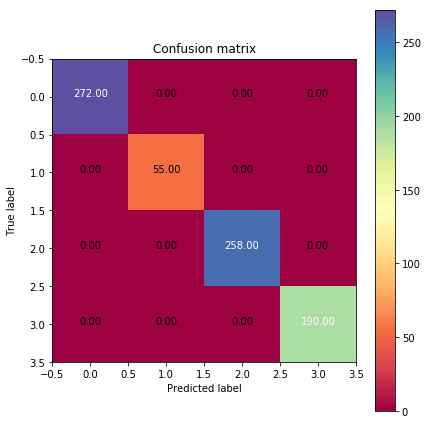

--------------------------------------------------
--------------------------------------------------
USING ONE VS REST MODEL
Accuracy is: 1.0
Classification Report:
              precision    recall  f1-score   support

    sitting       1.00      1.00      1.00       272
    walking       1.00      1.00      1.00        55
laying_down       1.00      1.00      1.00       258
   standing       1.00      1.00      1.00       190

avg / total       1.00      1.00      1.00       775

Confusion Matrix
 [[272   0   0   0]
 [  0  55   0   0]
 [  0   0 258   0]
 [  0   0   0 190]]


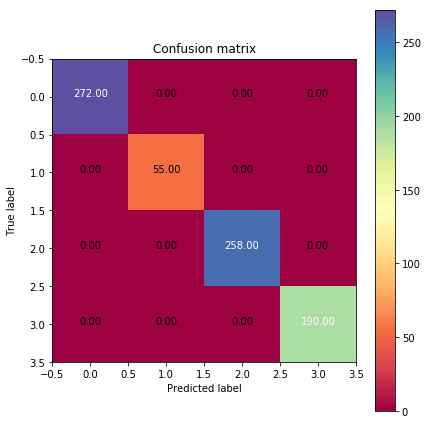

--------------------------------------------------
--------------------------------------------------
USING ONE VS ONE MODEL
Accuracy is: 0.9922879177377892
Classification Report:
              precision    recall  f1-score   support

    sitting       0.99      0.99      0.99       261
    walking       1.00      1.00      1.00        63
laying_down       1.00      0.99      0.99       264
   standing       0.98      0.99      0.99       190

avg / total       0.99      0.99      0.99       778

Confusion Matrix
 [[259   0   0   2]
 [  0  63   0   0]
 [  1   0 261   2]
 [  1   0   0 189]]


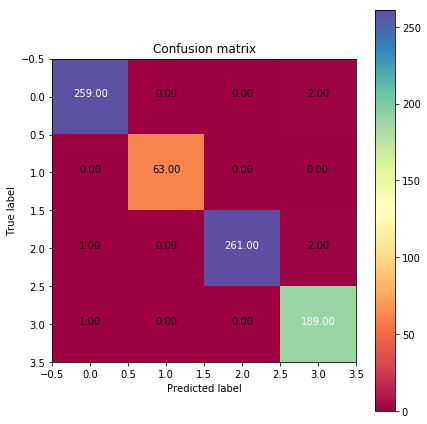

--------------------------------------------------
--------------------------------------------------
USING ONE VS REST MODEL
Accuracy is: 0.9961439588688946
Classification Report:
              precision    recall  f1-score   support

    sitting       1.00      0.99      0.99       261
    walking       1.00      1.00      1.00        63
laying_down       1.00      1.00      1.00       264
   standing       0.99      1.00      0.99       190

avg / total       1.00      1.00      1.00       778

Confusion Matrix
 [[259   0   0   2]
 [  0  63   0   0]
 [  1   0 263   0]
 [  0   0   0 190]]


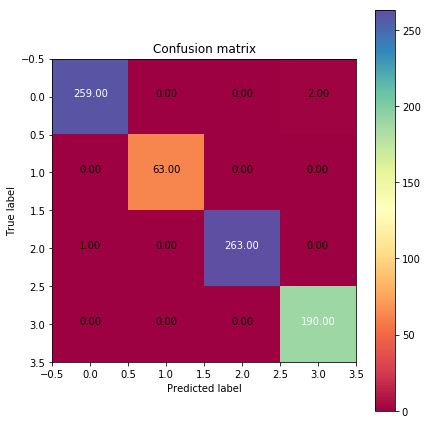

--------------------------------------------------


OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          n_jobs=1)

In [8]:
############## Random Forest Classifier ##############
search_best_params = False
load_model = False
persons = ['ayush', 'shrey', 'varun']
if_present = [[1,1,1,0], [1,0,1,1], [1,0,1,1]]
sensors = ['accelerometer', 'gyroscope', 'magnetic']
target_names = ['sitting', 'walking','laying_down','standing']
data, labels, train_data, train_labels, test_data, test_labels = get_data(persons, if_present, sensors)
RFClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsone', search_best_params=False, load_model=load_model)
RFClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsrest', search_best_params=False, load_model=load_model)

# For Acceleration only
sensors = ['accelerometer']
data, labels, train_data, train_labels, test_data, test_labels = get_data(persons, if_present, sensors)
RFClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsone', 
             search_best_params=False, load_model=load_model, sensor='acc_')
RFClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsrest', 
             search_best_params=False, load_model=load_model, sensor='acc_')

--------------------------------------------------
USING ONE VS ONE MODEL
Accuracy is: 0.5754838709677419
Classification Report:
              precision    recall  f1-score   support

    sitting       0.55      0.71      0.62       263
    walking       0.68      0.74      0.71        54
laying_down       0.56      0.63      0.59       266
   standing       0.70      0.27      0.38       192

avg / total       0.60      0.58      0.56       775

Confusion Matrix
 [[187   7  60   9]
 [  1  40   3  10]
 [ 87   8 168   3]
 [ 68   4  69  51]]


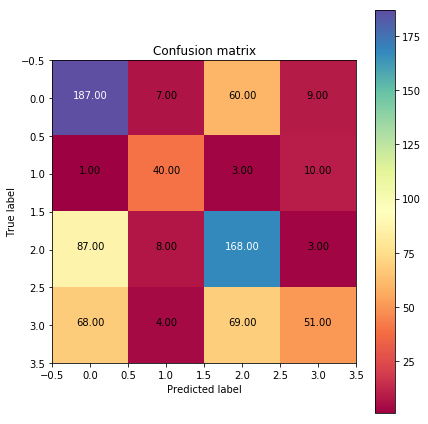

--------------------------------------------------
--------------------------------------------------
USING ONE VS REST MODEL
Accuracy is: 0.7070967741935484
Classification Report:
              precision    recall  f1-score   support

    sitting       0.60      0.88      0.72       263
    walking       0.79      0.96      0.87        54
laying_down       0.75      0.63      0.69       266
   standing       0.95      0.51      0.66       192

avg / total       0.75      0.71      0.70       775

Confusion Matrix
 [[231   3  27   2]
 [  0  52   2   0]
 [ 88   7 168   3]
 [ 64   4  27  97]]


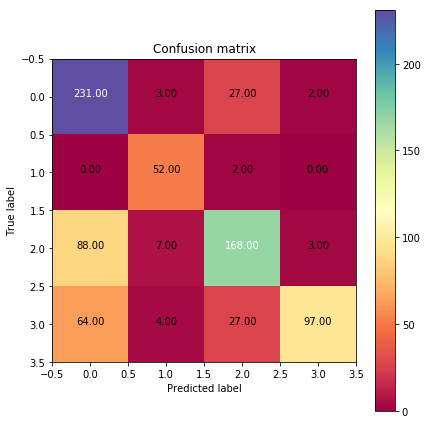

--------------------------------------------------
--------------------------------------------------
USING ONE VS ONE MODEL
Accuracy is: 0.9974293059125964
Classification Report:
              precision    recall  f1-score   support

    sitting       1.00      1.00      1.00       254
    walking       1.00      0.99      0.99        75
laying_down       0.99      1.00      1.00       248
   standing       1.00      1.00      1.00       201

avg / total       1.00      1.00      1.00       778

Confusion Matrix
 [[254   0   0   0]
 [  0  74   1   0]
 [  0   0 248   0]
 [  0   0   1 200]]


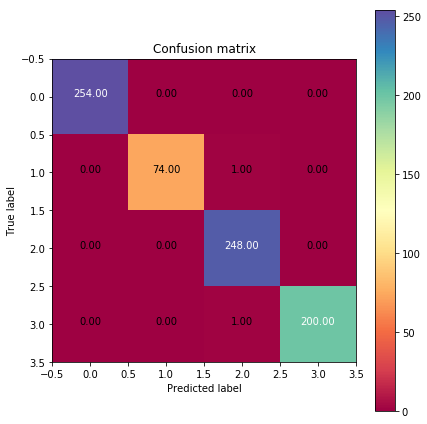

--------------------------------------------------
--------------------------------------------------
USING ONE VS REST MODEL
Accuracy is: 0.9974293059125964
Classification Report:
              precision    recall  f1-score   support

    sitting       1.00      1.00      1.00       254
    walking       1.00      1.00      1.00        75
laying_down       1.00      1.00      1.00       248
   standing       1.00      1.00      1.00       201

avg / total       1.00      1.00      1.00       778

Confusion Matrix
 [[253   0   0   1]
 [  0  75   0   0]
 [  1   0 247   0]
 [  0   0   0 201]]


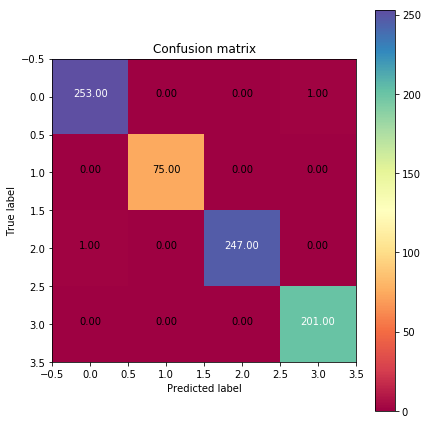

--------------------------------------------------


OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          n_jobs=1)

In [11]:
############## SVM ##############
search_best_params = False
load_model = False
persons = ['ayush', 'shrey', 'varun']
if_present = [[1,1,1,0], [1,0,1,1], [1,0,1,1]]
sensors = ['accelerometer', 'gyroscope', 'magnetic']
target_names = ['sitting', 'walking','laying_down','standing']
data, labels, train_data, train_labels, test_data, test_labels = get_data(persons, if_present, sensors)
SVMClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsone', search_best_params=False, load_model=load_model)
SVMClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsrest', search_best_params=False, load_model=load_model)

# For Acceleration only
sensors = ['accelerometer']
data, labels, train_data, train_labels, test_data, test_labels = get_data(persons, if_present, sensors)
RFClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsone', 
             search_best_params=False, load_model=load_model, sensor='acc_')
RFClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsrest', 
             search_best_params=False, load_model=load_model, sensor='acc_')

In [12]:
############## Decision Tree Classifier ##############
search_best_params = True
load_model = False
persons = ['ayush', 'shrey', 'varun']
#sensors = ['accelerometer', 'gyroscope', 'magnetic']
sensors = ['accelerometer']
target_names = ['sitting', 'walking','laying_down','standing']
data, labels, train_data, train_labels, test_data, test_labels = get_data(persons)
DTClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsone', search_best_params=search_best_params, load_model=load_model)
DTClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsrest', search_best_params=search_best_params, load_model=load_model)

TypeError: get_data() missing 2 required positional arguments: 'if_present' and 'sensors'

# TEST ON ANOTHER PERSON

In [13]:
# Testing Function
def test_model(files, sensor):
    string_annot = ['acc_', 'gyr_', 'mag_']
    dfs = []
    for i, file in enumerate(files):
        file = compute_feats(file, show_plots=False)
        file.columns = [string_annot[i] + str(col) for col in file.columns]
        dfs.append(file)

    min_len = min([len(df) for df in dfs])
    final_df = dfs[0]
    for df in dfs[1:]:
        final_df = pd.concat([final_df.loc[:min_len-1, :final_df.columns[-2]], 
                              df.loc[:min_len-1, :]], axis=1)
        
    final_df.columns = [i if i == len(final_df.columns)-1 else final_df.columns[i] for i in range(len(final_df.columns))]
    label_col = len(final_df.columns) - 1
    labels = final_df[label_col]
    labels = labels.astype('int')
    data = final_df.drop(label_col, axis=1)    
    use_models = [sensor+'RFClassifier-onevsone', sensor+'RFClassifier-onevsrest', 
                  sensor+'SVMClassifier-onevsone', sensor+'SVMClassifier-onevsrest']
    for use_model in use_models:
        clf = pickle.load(open('models/' + use_model + '.pkl', 'rb'))
        y_pred = clf.predict(data)
        print('-'*50)
        print('USING %s MODEL' %use_model)
        print('Accuracy is:', accuracy_score(labels, y_pred))
        print('Classification Report:\n', classification_report(labels, y_pred,target_names=target_names))
        print('Confusion Matrix\n', confusion_matrix(labels, y_pred))
        plot_confusion_matrix(confusion_matrix(labels, y_pred), target_names)
        print('-'*50)
        
        
def test_model_api(files):
    ''' This function is for API call made by Azure '''
    
    string_annot = ['acc_', 'gyr_', 'mag_']
    dfs = []
    for i, file in enumerate(files):
        file = compute_feats(file, show_plots=False)
        file.columns = [string_annot[i] + str(col) for col in file.columns]
        dfs.append(file)

    min_len = min([len(df) for df in dfs])
    final_df = dfs[0]
    for df in dfs[1:]:
        final_df = pd.concat([final_df.loc[:min_len-1, :final_df.columns[-2]], 
                              df.loc[:min_len-1, :]], axis=1)
        
    final_df.columns = [i if i == len(final_df.columns)-1 else final_df.columns[i] for i in range(len(final_df.columns))]
    label_col = len(final_df.columns) - 1
    labels = final_df[label_col]
    labels = labels.astype('int')
    data = final_df.drop(label_col, axis=1)
    return data

--------------------------------------------------
JUST WITH ACCELEROMETER DATA
--------------------------------------------------
USING acc_RFClassifier-onevsone MODEL
Accuracy is: 1.0
Classification Report:
              precision    recall  f1-score   support

    sitting       1.00      1.00      1.00       149

avg / total       1.00      1.00      1.00       149

Confusion Matrix
 [[149]]


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 1, does not match size of target_names, 4
  .format(len(labels), len(target_names))


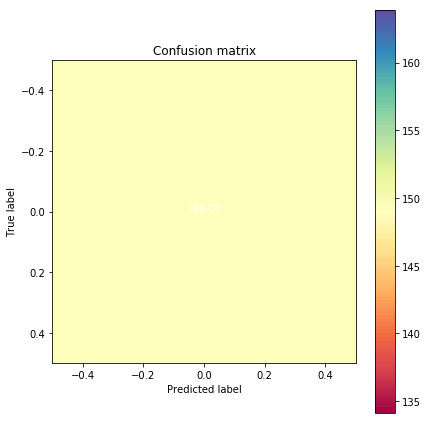

--------------------------------------------------
--------------------------------------------------
USING acc_RFClassifier-onevsrest MODEL
Accuracy is: 1.0
Classification Report:
              precision    recall  f1-score   support

    sitting       1.00      1.00      1.00       149

avg / total       1.00      1.00      1.00       149

Confusion Matrix
 [[149]]


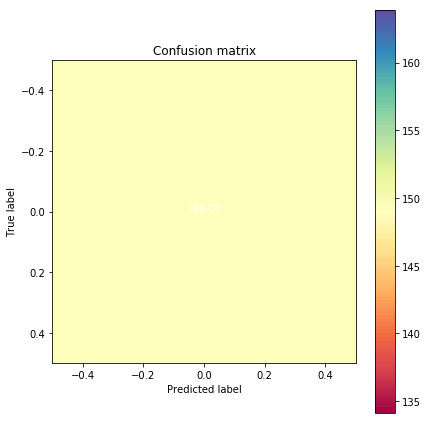

--------------------------------------------------


ValueError: X.shape[1] = 69 should be equal to 75, the number of features at training time

In [14]:
df_acc = pd.read_csv('data/csv/bhargav/accelerometer-sit.csv', header=None)
df_gyro = pd.read_csv('data/csv/bhargav/gyroscope-sit.csv', header=None)
df_mag = pd.read_csv('data/csv/bhargav/magnetic-sit.csv', header=None)

sit_df_acc = pd.read_csv('data/csv/bhargav/accelerometer-sit.csv', header=None)
sit_df_gyro = pd.read_csv('data/csv/bhargav/gyroscope-sit.csv', header=None)
sit_df_mag = pd.read_csv('data/csv/bhargav/magnetic-sit.csv', header=None)

print('-'*50)
print('JUST WITH ACCELEROMETER DATA')
test_model([sit_df_acc], 'acc_')

print('-'*50)
print('WITH ALL 3 SENSORS DATA')
test_model([sit_df_acc, sit_df_gyro, sit_df_mag], '')

print('-'*50)
print('JUST WITH ACCELEROMETER DATA')
test_model([df_acc], 'acc_')

print('-'*50)
print('FOR SITTING')
print('-'*50)
print('WITH ALL 3 SENSORS DATA')
test_model([df_acc, df_gyro, df_mag], '')



In [15]:
print((df.head()))
df[138].value_counts().plot(kind='bar', title='Training examples by activity type')
plt.show()

      mag_0     mag_1     mag_2     mag_3     mag_4     mag_5     mag_6  \
0  0.049544  0.045658  0.028727  0.014468  0.016024 -0.008416  0.008175   
1  0.051555  0.044907  0.040626  0.005475  0.006084 -0.003039  0.002764   
2  0.054264  0.049354  0.044475  0.008398  0.008731 -0.008149  0.002370   
3  0.063809  0.057145  0.044475  0.016549  0.029260 -0.012225  0.005100   
4  0.071484  0.057145  0.058203  0.004925  0.003569 -0.001369  0.008510   

      mag_7     mag_8     mag_9   ...      mag_60    mag_61    mag_62  \
0 -0.022841  0.016853  0.021512   ...    0.017239  0.036311  0.728326   
1 -0.018113  0.010245  0.008795   ...    0.008238  0.007451  0.324858   
2 -0.039742  0.021076  0.014012   ...    0.019098  0.009515  0.224920   
3 -0.039742  0.021988  0.021621   ...    0.054883  0.014334  0.139576   
4 -0.029722  0.018776  0.011313   ...    0.042529  0.006427  0.108098   

     mag_63    mag_64    mag_65    mag_66    mag_67    mag_68  mag_69  
0  0.681179  0.630031  0.683201 -0.966

KeyError: 138

In [16]:
def plot_activity(activity, df):
    data = df[df[22] == activity][[1, 2, 3]][:200]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
plot_activity(0, df)
plt.show()
plot_activity(1, df)
plt.show()
plot_activity("standing", df)
plt.show()
plot_activity("laying_down", df)
plt.show()

KeyError: 22